In [1]:
import pandas as pd
import os
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt

/cluster/apps/nss/gcc-6.3.0/python/3.8.5/x86_64/lib64/python3.8/site-packages/pyproj/__init__.py:78: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [104]:
def read_output(output_directory, last_iter=-1):
    drt_legs = []
    global_stats = []
    drt_trips_stats = []
    drt_predictions = []
    drt_vehicles_stats = []
    
    iter_0_path = os.path.join(output_directory,'ITERS','it.0')
    binned = '0.drt_zonalAndTimeBinWaitingTime.csv' in os.listdir(iter_0_path)
    if binned:
        binned_wait_time = []
        binned_delay_factor = []
    
    if last_iter == -1:
        last_iter = len(os.listdir(output_directory + '/ITERS')) - 1
    for i in tqdm(range(last_iter+1)):
        iter_path = os.path.join(output_directory,'ITERS','it.' + str(i)) + \
                    '/' + str(i) + '.'
        global_stats.append(pd.read_csv(iter_path + 'drt_globalStats.csv', sep=';'))
        if binned:
            binned_wait_time.append(pd.read_csv(iter_path + 'drt_zonalAndTimeBinWaitingTime.csv', sep=';'))
            binned_delay_factor.append(pd.read_csv(iter_path + 'drt_distanceAndTimeBinDelayFactor.csv', sep=';'))
        
        drt_legs.append(pd.read_csv(iter_path + 'drt_legs_drt.csv', sep=';'))
        drt_trips_stats.append(pd.read_csv(iter_path + 'drt_drtTripsStats.csv', sep=';'))
        drt_predictions.append(pd.read_csv(iter_path + 'drt_drtTripsPredictions.csv', sep=';'))
        drt_vehicles_stats.append(pd.read_csv(iter_path + 'vehicleDistanceStats_drt.csv', sep=';'))

    drt_costs = pd.read_csv(os.path.join(output_directory,'drt_drtCosts.csv'), sep=';')
    drt_costs.columns = drt_costs.columns.str.replace(' ', '')
    d = {'drt_legs': drt_legs,
         'global_stats': global_stats,
         'drt_trips_stats': drt_trips_stats,
         'drt_predictions': drt_predictions,
         'drt_costs': drt_costs,
         'drt_vehicles_stats': drt_vehicles_stats
        }
    
    if binned:
        d['binned_wait_time'] = binned_wait_time
        d['binned_delay_factor'] = binned_delay_factor
    
    if 'drt_link2FixedZones.csv' in os.listdir(output_directory):
        link2zones_csv = pd.read_csv(os.path.join(output_directory,'drt_link2FixedZones.csv'), sep=';')
        link2zones_csv = link2zones_csv.set_index('link_id')
        link2zones = {}
        for link_id, zone in link2zones_csv.iterrows():
            link2zones[link_id] = zone.zone
        fixed_zones = gpd.read_file(os.path.join(output_directory,'drt_FixedZones.shp'))
        d['link2zones'] = link2zones
        d['fixedZones'] = fixed_zones
    #Read stopwatch.txt
    stopwatch = pd.read_csv(os.path.join(output_directory,'stopwatch.txt'), sep='\t')
    d['stopwatch'] = stopwatch
    
    return d

In [105]:
path = '/cluster/work/ivt_vpl/mfrancesc/SA_scenario/astra_small/'

In [106]:
outputs = {}
fleet_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for f in fleet_sizes:
    outputs[f] = read_output(os.path.join(path, 'fleet_' + str(f)))

100%|██████████| 101/101 [00:53<00:00,  1.89it/s]


In [107]:
outputs['storage_1_400'] = read_output(os.path.join(path, 'storage_1', 'fleet_400'))

100%|██████████| 101/101 [00:49<00:00,  2.04it/s]


In [108]:
outputs['useDF_400'] = read_output(os.path.join(path, 'useDelayFactor', 'fleet_400'))

100%|██████████| 101/101 [00:48<00:00,  2.10it/s]


In [55]:
outputs.keys()

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 'storage_1_400', 'useDF_400'])

In [111]:
def plot_request_per_fleet_size(outputs, fleet_sizes = fleet_sizes, last_iter=100, add_other_scenarios=True):
    n_requests = []
    for f in fleet_sizes:
        n_requests.append(outputs[f]['drt_trips_stats'][last_iter].shape[0])
    plt.plot(fleet_sizes, n_requests, 'o-')
    if add_other_scenarios:
        other_scenarios = [a for a in outputs.keys() if isinstance(a,str)]
        for a in other_scenarios:
            f_size = int(a.split('_')[-1])
            label = '_'.join(a.split('_')[:-1])
            value = outputs[a]['drt_trips_stats'][last_iter].shape[0]
            plt.plot(f_size, value, 'o', label=label)
        plt.legend()
    plt.xlabel('Fleet size')
    plt.ylabel('Number of requests')
    plt.show()

In [112]:
def plot_distance_fare_per_fleet_size(outputs, fleet_sizes = fleet_sizes, last_iter=100, add_other_scenarios=True):
    cost = []
    for f in fleet_sizes:
        cost_df = outputs[f]['drt_costs'].copy(deep=True)
        cost_df = cost_df.set_index('iteration', drop=True)
        cost.append(cost_df.loc[last_iter]['drtCostPerKm'])
    plt.plot(fleet_sizes, cost, 'o-')
    if add_other_scenarios:
        other_scenarios = [a for a in outputs.keys() if isinstance(a,str)]
        for a in other_scenarios:
            f_size = int(a.split('_')[-1])
            label = '_'.join(a.split('_')[:-1])
            cost_df = outputs[a]['drt_costs'].copy(deep=True)
            cost_df = cost_df.set_index('iteration', drop=True)
            value = cost_df.loc[last_iter]['drtCostPerKm']
            plt.plot(f_size, value, 'o', label=label)
        plt.legend()
    plt.xlabel('Fleet size')
    plt.ylabel('CHF/km')
    plt.show()

In [113]:
def plot_waiting_time_per_fleet_size(outputs, fleet_sizes = fleet_sizes, last_iter=100, add_other_scenarios=True):
    waiting_time_avg = []
    waiting_time_90 = []
    for f in fleet_sizes:
        waiting_time_avg.append(outputs[f]['drt_trips_stats'][last_iter]['waitTime'].mean() / 60)
        waiting_time_90.append(outputs[f]['drt_trips_stats'][last_iter]['waitTime'].quantile(0.9) / 60)
    plt.plot(fleet_sizes, waiting_time_avg, 'o-', label='Mean')
    plt.plot(fleet_sizes, waiting_time_90, '^--', label='90% Quant', color='C0')
    if add_other_scenarios:
        other_scenarios = [a for a in outputs.keys() if isinstance(a,str)]
        for a in other_scenarios:
            f_size = int(a.split('_')[-1])
            label = '_'.join(a.split('_')[:-1])
            value_m = outputs[a]['drt_trips_stats'][last_iter]['waitTime'].mean() / 60
            value_90 = outputs[a]['drt_trips_stats'][last_iter]['waitTime'].quantile(0.9) / 60
            plt.plot(f_size, value_m, 'o', label=label)
            plt.plot(f_size, value_90, '^', label=label)
        plt.legend()
    plt.xlabel('Fleet size')
    plt.ylabel('Waiting time [min]')
    plt.show()

In [118]:
def plot_vehicles_stats(outputs, fleet_sizes = fleet_sizes, last_iter=100, add_other_scenarios=True):
    # 2x2 plot
    fig, axs = plt.subplots(2, 2, figsize=(12,10))
    # total vehicles distance
    total_distance = []
    for f in fleet_sizes:
        total_distance.append(outputs[f]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].sum() / 1000)
    axs[0,0].plot(fleet_sizes, total_distance, 'o-')
    axs[0,0].set_xlabel('Fleet size')
    axs[0,0].set_ylabel('Distance [km]')
    axs[0,0].set_title('Total fleet distance')
    # total empty distance
    total_empty_distance = []
    for f in fleet_sizes:
        total_empty_distance.append(outputs[f]['drt_vehicles_stats'][last_iter]['emptyDistance_m'].sum() / 1000)
    axs[0,1].plot(fleet_sizes, total_empty_distance, 'o-')
    axs[0,1].set_xlabel('Fleet size')
    axs[0,1].set_ylabel('Distance [km]')
    axs[0,1].set_title('Total empty distance')
    # empty distance share
    empty_distance_share = []
    for f in fleet_sizes:
        total_distance = outputs[f]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].sum() / 1000
        total_empty_distance = outputs[f]['drt_vehicles_stats'][last_iter]['emptyDistance_m'].sum() / 1000
        empty_distance_share.append(total_empty_distance / total_distance * 100)
    axs[1,0].plot(fleet_sizes, empty_distance_share, 'o-')
    axs[1,0].set_xlabel('Fleet size')
    axs[1,0].set_ylabel('Share [%]')
    axs[1,0].set_title('Empty distance share')
    #Mean and max daily per vehicle distance
    mean_daily_distance = []
    max_daily_distance = []
    for f in fleet_sizes:
        mean_daily_distance.append(outputs[f]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].mean() / 1000)
        max_daily_distance.append(outputs[f]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].max() / 1000)
    axs[1,1].plot(fleet_sizes, mean_daily_distance, 'o-', label='Mean')
    axs[1,1].plot(fleet_sizes, max_daily_distance, '^--', label='Max', color='C0')
    axs[1,1].set_xlabel('Fleet size')
    axs[1,1].set_ylabel('Distance [km]')
    axs[1,1].set_title('Daily per vehicle distance')
    axs[1,1].legend()
    if add_other_scenarios:
        other_scenarios = [a for a in outputs.keys() if isinstance(a,str)]
        for a in other_scenarios:
            f_size = int(a.split('_')[-1])
            label = '_'.join(a.split('_')[:-1])
            value = outputs[a]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].sum() / 1000
            axs[0,0].plot(f_size, value, 'o', label=label)
            value = outputs[a]['drt_vehicles_stats'][last_iter]['emptyDistance_m'].sum() / 1000
            axs[0,1].plot(f_size, value, 'o', label=label)
            total_distance = outputs[a]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].sum() / 1000
            total_empty_distance = outputs[a]['drt_vehicles_stats'][last_iter]['emptyDistance_m'].sum() / 1000
            value = total_empty_distance / total_distance * 100
            axs[1,0].plot(f_size, value, 'o', label=label)
            value_m = outputs[a]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].mean() / 1000
            value_max = outputs[a]['drt_vehicles_stats'][last_iter]['drivenDistance_m'].max() / 1000
            axs[1,1].plot(f_size, value_m, 'o', label=label)
            axs[1,1].plot(f_size, value_max, '^', label=label)
        axs[0,0].legend()
        axs[0,1].legend()
        axs[1,0].legend()
        axs[1,1].legend()
    plt.show()

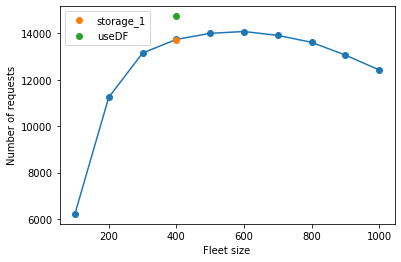

In [81]:
plot_request_per_fleet_size(outputs)

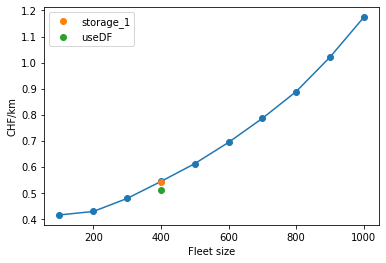

In [100]:
plot_distance_fare_per_fleet_size(outputs)

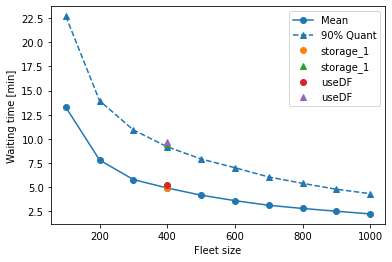

In [97]:
plot_waiting_time_per_fleet_size(outputs)

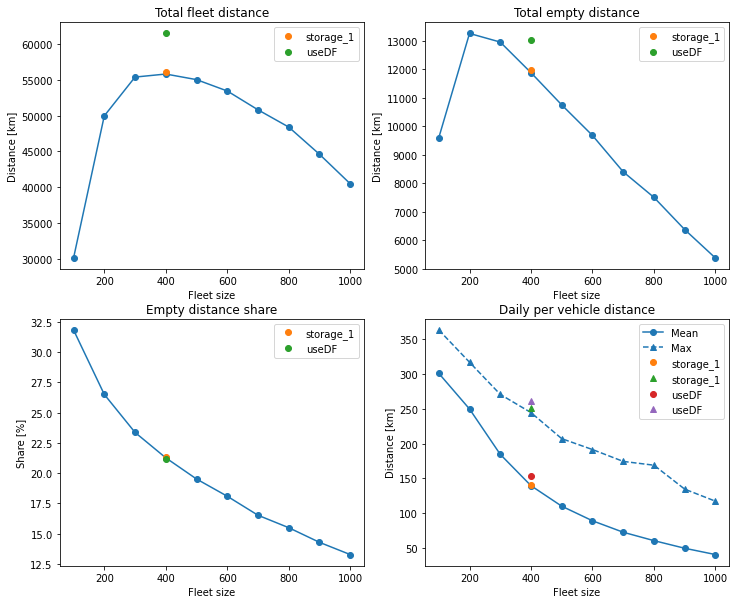

In [119]:
plot_vehicles_stats(outputs)

In [122]:
def op_by_time_bin(drt_trips_stats, column, op, start_time=6, end_time=24, bin_duration_min=30):
    legs = drt_trips_stats.copy()
    n_bins = (end_time - start_time) * 60 // bin_duration_min
    bins = [start_time*3600 + i*bin_duration_min*60 for i in range(0,n_bins+1)]
    legs['time_bin'] = pd.cut(legs.startTime, bins).map(lambda x: int((x.left + x.right)/2))
    grouped = legs.groupby(['time_bin'])[column].agg(op)
    return grouped

In [137]:
def plot_waiting_time_over_day(outputs, fleet_sizes = [200, 400, 600], last_iter=100, time_bin_min=15, start_time=6, end_time=24):
    # 1x2 plot sharing y axis but y labels in both
    fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    # waiting time over day by time bin
    for f in fleet_sizes:
        df = outputs[f]['drt_trips_stats'][last_iter].copy(deep=True)
        df['waitTime_min'] = df['waitTime'] / 60
        # compute mean and 90% quantile
        waiting_time = op_by_time_bin(df, 'waitTime_min', 'mean', start_time, end_time, time_bin_min)
        axs[0].plot(waiting_time.index, waiting_time, '-', label=str(f))
        waiting_time = op_by_time_bin(df, 'waitTime_min', lambda x: x.quantile(0.9), start_time, end_time, time_bin_min)
        axs[1].plot(waiting_time.index, waiting_time, '-', label=str(f))
    xticks = [z*3600 for z in range(start_time, end_time+1, 2)]
    xticks_labels = [str(z) + 'h' for z in range(start_time, end_time+1, 2)]
    axs[0].set_xlabel('Time [h]')
    axs[0].set_ylabel('Waiting time [min]')
    axs[0].set_title('Mean waiting time over day')
    axs[0].legend()
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(xticks_labels)
    axs[1].set_xlabel('Time [h]')
    axs[1].set_ylabel('Waiting time [min]')
    axs[1].set_title('90% Quantile waiting time over day')
    axs[1].legend()
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(xticks_labels)
    axs[1].yaxis.set_tick_params(labelleft=True)
    plt.show()

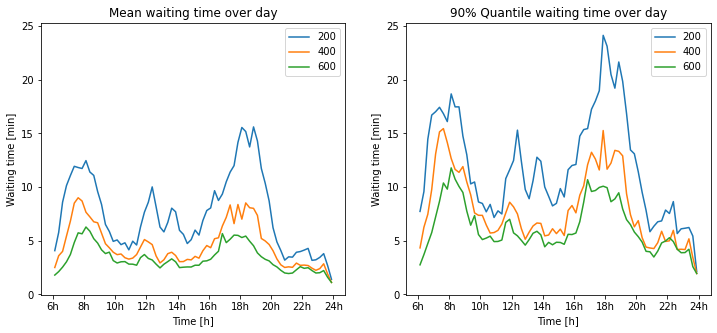

In [138]:
plot_waiting_time_over_day(outputs)

In [139]:
outputs[100]['drt_trips_stats'][100].columns

Index(['personId', 'tripIndex', 'startTime', 'arrivalTime', 'totalTravelTime',
       'routerUnsharedTime', 'estimatedUnsharedTime', 'delayFactor',
       'waitTime', 'startX', 'startY', 'endX', 'endY', 'euclideanDistance'],
      dtype='object')

In [140]:
def op_by_euclidean_distance_bin(drt_trips_stats, column, op, min_distance=0, max_distance=5000, bin_distance_m=250):
    legs = drt_trips_stats.copy()
    n_bins = (max_distance - min_distance) // bin_distance_m
    distance_bins = [min_distance + i*bin_distance_m for i in range(n_bins + 1)]
    legs['distance_bin'] = pd.cut(legs.euclideanDistance, distance_bins).map(lambda x: int((x.left + x.right)/2))
    grouped = legs.groupby(['distance_bin'])[column].agg(op)
    return grouped

In [168]:
def plot_distance_distribution(outputs, fleet_size=[200,400,600], last_iter=100, distance_bin_m=250, min_distance=0, max_distance=10000):
    plt.figure(figsize=(6,6))
    for f in fleet_size:
        df = outputs[f]['drt_trips_stats'][last_iter].copy(deep=True)
        distance = op_by_euclidean_distance_bin(df, 'euclideanDistance', 'count', min_distance, max_distance, distance_bin_m)
        plt.plot(distance.index, distance, '-', label=str(f))
    xticks = [z*1000 for z in range(min_distance//1000, max_distance//1000+1, 1)]
    xticks_labels = [str(z) + 'km' for z in range(min_distance//1000, max_distance//1000+1, 1)]
    plt.xlabel('Distance [km]')
    plt.ylabel('Number of requests')
    plt.title('Distance distribution')
    plt.legend()
    plt.xticks(xticks, xticks_labels)
    plt.show()

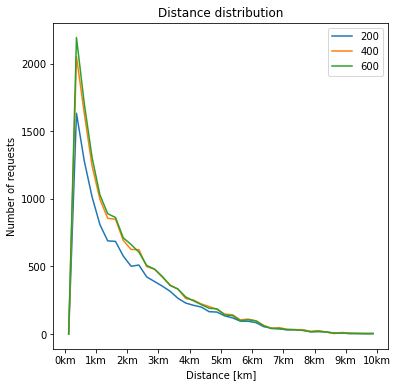

In [170]:
plot_distance_distribution(outputs, distance_bin_m=250)